In [38]:
import os
import time

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras import(
    Sequential,
    layers,
    regularizers,
    callbacks,
    optimizers,
    losses
)
import tensorflow_hub as hub

In [2]:
print(f"Tensorflow version is {tf.version.VERSION}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not available")
print(f"GPU device => {device_name}")


Tensorflow version is 2.8.0
GPU device => /device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



# Constants

In [27]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

TRAIN_FILENAMES = "gs://practical-ml-vision-book/flowers_tfr/train-*"
VALID_FILENAMES = "gs://practical-ml-vision-book/flowers_tfr/valid-*"

BATCH_SIZE = 256 if device_name == '/device:GPU:0' else 32
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Helper Functions

In [5]:
def training_plot(metrics, history):
    _, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls="dashed")
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history["val_" + metric])
        ax[idx].legend([metric, "val_" + metric])


In [33]:
def get_logdir():
    run_id = time.strftime('run_%Y_%m_%d-%H%M%S')
    return os.path.join('..', '..', 'reports', 'logs', run_id)

# Reading TF Records

(240, 320, 3)
tf.Tensor(0.35263804, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847864, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729656, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.2767833, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305508, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


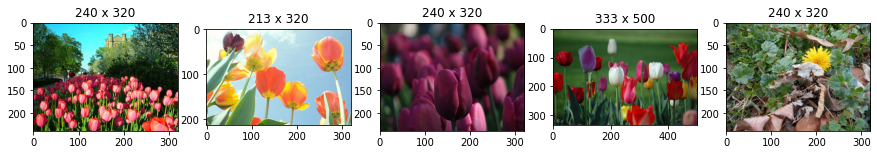

In [17]:
def parse_tfr(proto):
    feature_description = {
        "image": tf.io.VarLenFeature(tf.float32),
        "shape": tf.io.VarLenFeature(tf.int64),
        "label": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label_int": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    record = tf.io.parse_single_example(proto, feature_description)
    shape = tf.sparse.to_dense(record["shape"])
    img = tf.reshape(tf.sparse.to_dense(record["image"]), shape)
    label_int = record["label_int"]
    return img, label_int


train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(TRAIN_FILENAMES)],
    compression_type="GZIP",
).map(parse_tfr)

train_subset = train_dataset.take(5)

_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_subset):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(f"{img.shape[0]} x {img.shape[1]}")


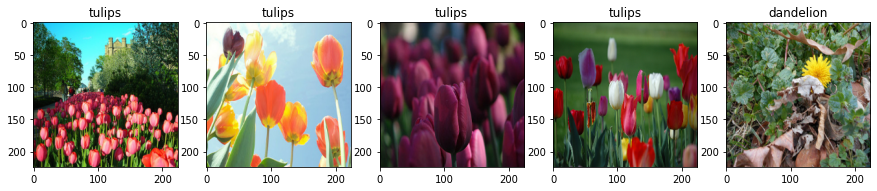

In [18]:
preproc_layers = Sequential(
    [layers.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH, input_shape=(None, None, 3))]
)


def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label


_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label) in enumerate(train_subset.map(apply_preproc)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(CLASS_NAMES[label])


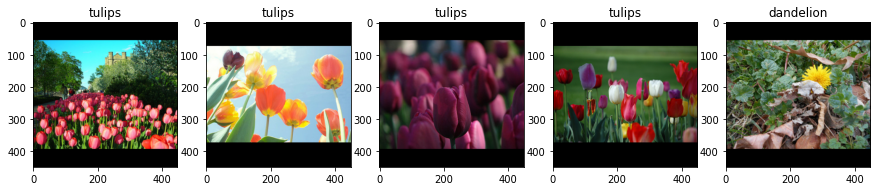

In [19]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH), label


_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label) in enumerate(train_subset.map(apply_preproc)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(CLASS_NAMES[label])


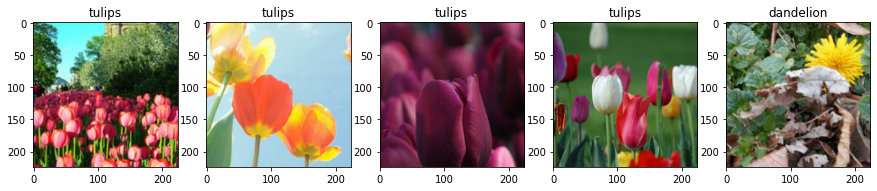

In [22]:
# Combine resize with padding and the center-crop
preproc_layers = Sequential(
    [
        layers.Lambda(
            lambda img: tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH),
            input_shape=(None, None, 3),
        ),
        layers.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
    ]
)


def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label


_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label) in enumerate(train_subset.map(apply_preproc)):
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(CLASS_NAMES[label])


# Transfer Learning with MobileNet

In [43]:
# Load a pretrained model use it as part of our model
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

preproc_layers = Sequential(
    [
        layers.Lambda(
            lambda img: tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH),
            input_shape=(None, None, 3),
        ),
        layers.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
    ]
)


def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label


def train_and_evaluate(lrate=0.001, l1=0.0, l2=0.0, num_hidden=16):
    regularizer = regularizers.l1_l2(l1, l2)

    train_dataset = (
        tf.data.TFRecordDataset(
            [file for file in tf.io.gfile.glob(TRAIN_FILENAMES)],
            compression_type="GZIP",
        )
        .map(parse_tfr)
        .map(apply_preproc)
        .batch(BATCH_SIZE)
    )

    eval_dataset = (
        tf.data.TFRecordDataset(
            [file for file in tf.io.gfile.glob(VALID_FILENAMES)],
            compression_type="GZIP",
        )
        .map(parse_tfr)
        .map(apply_preproc)
        .batch(BATCH_SIZE)
    )

    list_layers = [
        hub.KerasLayer(
            MODEL_URL,
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name="mobilenet_embedding",
        ),
        layers.Dense(
            num_hidden,
            kernel_regularizer=regularizer,
            activation="elu",
            kernel_initializer="he_normal",
            name="dense_hidden",
        ),
        layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation="softmax",
            name="flower_prob",
        ),
    ]

    model = Sequential(list_layers, name="flower_classifier")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lrate),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    logs_dir = get_logdir()

    tensorboard_cb = callbacks.TensorBoard(logs_dir)

    print(model.summary())
    history = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=10,
        callbacks=[tensorboard_cb],
        verbose=2,
    )
    training_plot(["loss", "accuracy"], history)
    return model


In [36]:
!rm -r ../../reports/logs

Model: "flower_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
12/12 - 185s - loss: 1.2620 - accuracy: 0.5017 - val_loss: 0.8132 - val_accuracy: 0.7021 - 185s/epoch - 15s/step
Epoch 2/10
12/12 - 172s - loss: 0.5883 - accuracy: 0.7965 - val_loss: 0.5748 - val_accuracy: 0.7798 - 1

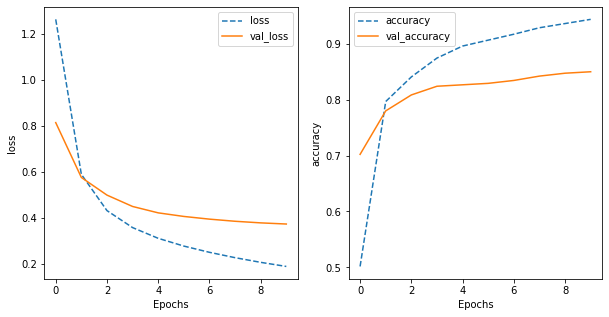

In [44]:
model = train_and_evaluate()

In [51]:
def plot_predictions(model, pattern):
    dataset = (
        tf.data.TFRecordDataset(
            [file for file in tf.io.gfile.glob(pattern)], compression_type="GZIP"
        )
        .map(parse_tfr)
        .map(apply_preproc)
        .shuffle(100)
    )

    nrows, ncols = 2, 3
    _, ax = plt.subplots(nrows, ncols, figsize=(25, 15))
    for idx, (img, label) in enumerate(dataset.take(6)):
        ax[idx // ncols, idx % ncols].imshow((img.numpy()))
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        title_label = '\u2714' if (label == pred_label) else f'\u2717 {label}'
        ax[idx // ncols, idx % ncols].set_title(f'{pred_label} ({prob:.2f}) {title_label}')
        ax[idx // ncols, idx % ncols].axis('off')

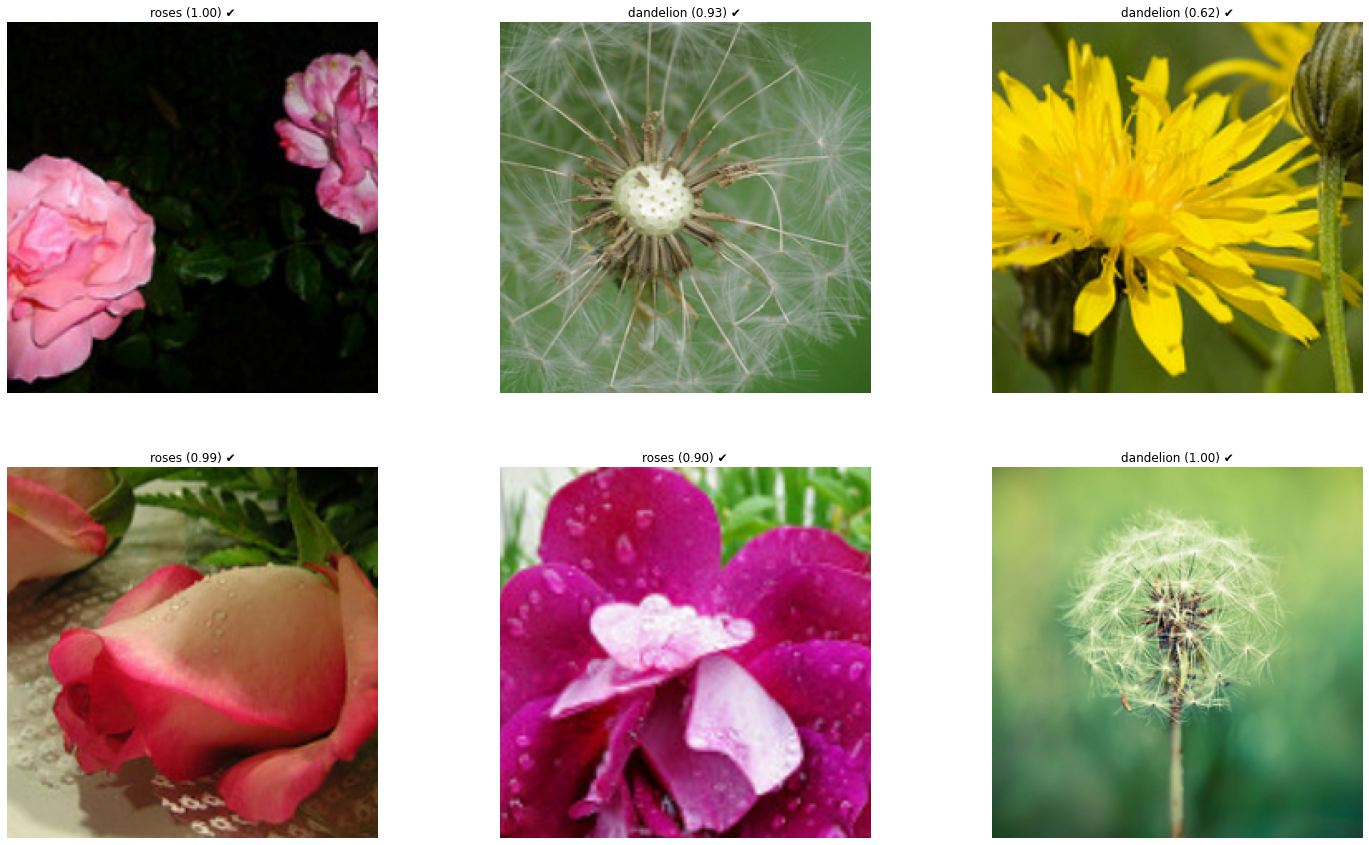

In [53]:
plot_predictions(model, VALID_FILENAMES)

In [55]:
%load_ext tensorboard
%tensorboard --logdir=../../reports/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19071), started 0:00:06 ago. (Use '!kill 19071' to kill it.)